## Trend Analysis Over Time

### Overview  
This notebook analyzes performance trends for Partizan Mozzart Bet Belgrade players during the 2022/23 season, focusing on how key metrics - points, valuation, and plus/minus - evolve across the regular season and playoffs. Points measure scoring output, valuation reflects overall contribution (a composite metric often used in European basketball to evaluate efficiency and impact), and plus/minus captures a player’s direct influence on the game’s point differential. The analysis calculates phase-wise averages, identifies players with the largest improvements in the playoffs, and visualizes trends over rounds for key players. A team-level summary provides context, statistical tests validate significant changes, and a comparative plot highlights relative performance among top players. The goal is to uncover trends, identify standout performers, and provide actionable insights for optimizing player roles and strategies.

In [19]:
import pandas as pd

file_path = "../data/partizan_2022_cleaned.csv"

df = pd.read_csv(file_path)

Filtering ensures the analysis focuses on individual player performance, with the active players subset highlighting those contributing on the court.

In [20]:
# filter
players = df[df['player'] != 'PARTIZAN MOZZART BET BELGRADE'].copy()
active_players = df[(df['player'] != 'PARTIZAN MOZZART BET BELGRADE') & (df['is_playing'] == True)].copy()

This step aims to quantify how player performance changes from the regular season to the playoffs, identifying those who improve or decline in key metrics.

In [21]:
# calculate averages by phase
phase_stats = active_players.groupby(['player', 'phase']).agg({
    'points': 'mean',
    'valuation': 'mean',
    'plus_minus': 'mean'
}).unstack()

# rename columns for clarity
phase_stats.columns = [f"{col[0]}_{col[1].lower().replace(' ', '_')}" for col in phase_stats.columns]

# compute differences
phase_stats['points_diff'] = phase_stats['points_playoffs'] - phase_stats['points_regular_season']
phase_stats['valuation_diff'] = phase_stats['valuation_playoffs'] - phase_stats['valuation_regular_season']
phase_stats['plus_minus_diff'] = phase_stats['plus_minus_playoffs'] - phase_stats['plus_minus_regular_season']



print("\nTop 5 Players by Valuation Increase in Playoffs:")
print(phase_stats.sort_values('valuation_diff', ascending=False)[['valuation_regular_season', 'valuation_playoffs', 'valuation_diff']].head(5))


Top 5 Players by Valuation Increase in Playoffs:
                    valuation_regular_season  valuation_playoffs  \
player                                                             
Punter Kevin                       14.176471                24.0   
Madar Yam                           4.515152                 8.2   
Leday Zach                         13.852941                15.6   
Smailagic Alen                      4.760000                 6.4   
Papapetrou Ioannis                  4.939394                 5.8   

                    valuation_diff  
player                              
Punter Kevin              9.823529  
Madar Yam                 3.684848  
Leday Zach                1.747059  
Smailagic Alen            1.640000  
Papapetrou Ioannis        0.860606  


### Interpretation  

- **Punter Kevin** shows the largest valuation increase (+9.82), jumping from 14.18 to 24.0, indicating a significant improvement in overall impact during the playoffs.  
- **Madar Yam** and **Leday Zach** also improved, with valuation increases of 3.68 and 1.75, respectively, suggesting they stepped up in the postseason.

This step aims to contextualize individual player trends by comparing them to the team’s overall performance in each phase.

In [22]:
# team-level averages by phase
team_stats = df[df['player'] == 'PARTIZAN MOZZART BET BELGRADE'].groupby('phase').agg({
    'points': 'mean',
    'valuation': 'mean',
    'plus_minus': 'mean'
}).round(2)


print("\nTeam Average Metrics by Phase:")
print(team_stats)


Team Average Metrics by Phase:
                points  valuation  plus_minus
phase                                        
PLAYOFFS         87.20      91.80         0.0
REGULAR SEASON   85.18      93.91         0.0


Print raw Plus/Minus to diagnose the issue.

In [23]:
# check raw plus/minus values for the team
team_data = df[df['player'] == 'PARTIZAN MOZZART BET BELGRADE']
print("\nRaw Plus/Minus Values for Team by Game:")
print(team_data[['phase', 'round', 'plus_minus']])


Raw Plus/Minus Values for Team by Game:
              phase  round  plus_minus
45         PLAYOFFS     39           0
54   REGULAR SEASON     32           0
63   REGULAR SEASON     15           0
72   REGULAR SEASON     30           0
81   REGULAR SEASON      9           0
90   REGULAR SEASON     23           0
98   REGULAR SEASON     10           0
107  REGULAR SEASON     19           0
116  REGULAR SEASON     18           0
125  REGULAR SEASON     20           0
134        PLAYOFFS     35           0
143  REGULAR SEASON     33           0
152  REGULAR SEASON     21           0
161  REGULAR SEASON     13           0
170  REGULAR SEASON      8           0
179  REGULAR SEASON     22           0
188  REGULAR SEASON     11           0
197        PLAYOFFS     36           0
206  REGULAR SEASON     34           0
215  REGULAR SEASON     16           0
224        PLAYOFFS     38           0
233  REGULAR SEASON     27           0
242  REGULAR SEASON     26           0
251  REGULAR SEASON    

### Interpretation  

- The team’s average points increased from 85.18 in the regular season to 87.20 in the playoffs (+2.02), suggesting a slight improvement in offensive output, which aligns with individual improvements like **Punter Kevin**’s scoring increase (+7.17).  
- Valuation decreased from 93.91 to 91.80 (-2.11), indicating a slight decline in overall efficiency and impact in the playoffs, despite the scoring increase. This contrasts with players like **Punter Kevin**, whose valuation surged (+9.82), suggesting he outperformed the team trend.  
- The plus/minus of 0.0 in both phases is incorrect because team row is an aggregation of player stats, and the plus_minus is not calculated as the game’s point differential (Partizan’s score minus opponent’s score). Instead, it’s set to 0 during summarization. Individual player plus_minus values (e.g., **Punter Kevin**’s 3.00, **Avramovic Aleksa**’s 3.67) are reliable and suggest the team likely had a positive point differential overall.

This step aims to determine whether the observed valuation increase in the playoffs is statistically significant, ensuring the improvement isn’t due to random variation.

In [24]:
from scipy.stats import ttest_rel

# filter for specific player
player_name = 'Punter Kevin'
player_data = active_players[active_players['player'] == player_name]

# separate regular season and playoffs
regular_vals = player_data[player_data['phase'] == 'REGULAR SEASON']['valuation']
playoff_vals = player_data[player_data['phase'] == 'PLAYOFFS']['valuation']

# ensure equal lengths for paired t-test (use minimum length if unequal)
min_length = min(len(regular_vals), len(playoff_vals))
if min_length > 0:
    regular_vals = regular_vals.head(min_length)
    playoff_vals = playoff_vals.head(min_length)
    t_stat, p_value = ttest_rel(regular_vals, playoff_vals)
    print(f"\nP-value for {player_name}'s Valuation Change (Regular Season to Playoffs): {p_value:.4f}")
else:
    print(f"\nInsufficient data for {player_name} to perform t-test.")


P-value for Punter Kevin's Valuation Change (Regular Season to Playoffs): 0.2786


### Interpretation  

- The p-value of 0.2786 is greater than the 0.05 threshold, indicating that **Punter Kevin**’s valuation increase from 14.18 to 24.0 (+9.82) is not statistically significant at the 5% level. This suggests that the observed increase could be due to random variation rather than a consistent improvement in performance.  
- The lack of statistical significance is likely due to the small sample size (only 5 playoff games compared to 5 regular season games), which reduces the test’s power to detect a difference. Additionally, variability in Punter Kevin’s game-to-game valuation may contribute to the high p-value.  
- Despite the lack of statistical significance, the practical significance of a nearly 10-point increase in valuation is notable, and **Punter Kevin**’s improvements in other metrics (e.g., points +7.17, plus/minus 3.00) reinforce his value as a key contributor in the playoffs.

This step aims to highlight which players improved their scoring output the most in the playoffs, indicating potential key contributors in high-stakes games.

In [25]:
# points increase in playoffs
print("\nTop 5 Players by Points Increase in Playoffs:")
print(phase_stats.sort_values('points_diff', ascending=False)[['points_regular_season', 'points_playoffs', 'points_diff']].head(5))


Top 5 Players by Points Increase in Playoffs:
                    points_regular_season  points_playoffs  points_diff
player                                                                 
Punter Kevin                    15.500000        22.666667     7.166667
Leday Zach                      10.852941        15.400000     4.547059
Papapetrou Ioannis               5.030303         7.600000     2.569697
Smailagic Alen                   5.000000         7.400000     2.400000
Madar Yam                        5.696970         6.600000     0.903030


### Interpretation  

- **Punter Kevin**’s scoring increased by 7.17 points per game (15.50 to 22.67), making him a standout offensive contributor in the playoffs, consistent with the team’s slight scoring increase (+2.02).  
- **Leday Zach** also showed a notable increase (+4.55), suggesting he stepped up his scoring in the postseason.  
- The team’s overall scoring increase (from 85.18 to 87.20) aligns with these individual improvements, indicating a broader offensive improvement.

This step aims to identify the most impactful players in terms of point differential, focusing on those with significant playing time to ensure reliability.

In [26]:
# filter players with minimum average seconds per game
min_seconds_per_game = 600
filtered_players = players.groupby('player').filter(lambda x: x['total_seconds'].mean() >= min_seconds_per_game)
avg_pm_filtered = filtered_players.groupby('player')['plus_minus'].mean()
top_pm_filtered = avg_pm_filtered.sort_values(ascending=False).head(5)


print("\nTop 5 Players by Average Plus/Minus (All Games, min 600 sec/game):")
print(top_pm_filtered)


Top 5 Players by Average Plus/Minus (All Games, min 600 sec/game):
player
Avramovic Aleksa    3.666667
Punter Kevin        3.000000
Lessort Mathias     2.947368
Exum Dante          2.657895
Leday Zach          2.051282
Name: plus_minus, dtype: float64


### Interpretation  

- **Avramovic Aleksa** leads with a plus/minus of 3.67, indicating a strong positive impact on the game, though his absence from the phase-wise comparison (due to missing playoff data) suggests limited postseason minutes.  
- **Punter Kevin** (3.00) and **Leday Zach** (2.05) appear again, reinforcing their importance as key contributors across multiple metrics.  


This step aims to visualize how key players’ performances evolve over the season, highlighting trends, peaks, and differences between regular season and playoffs.

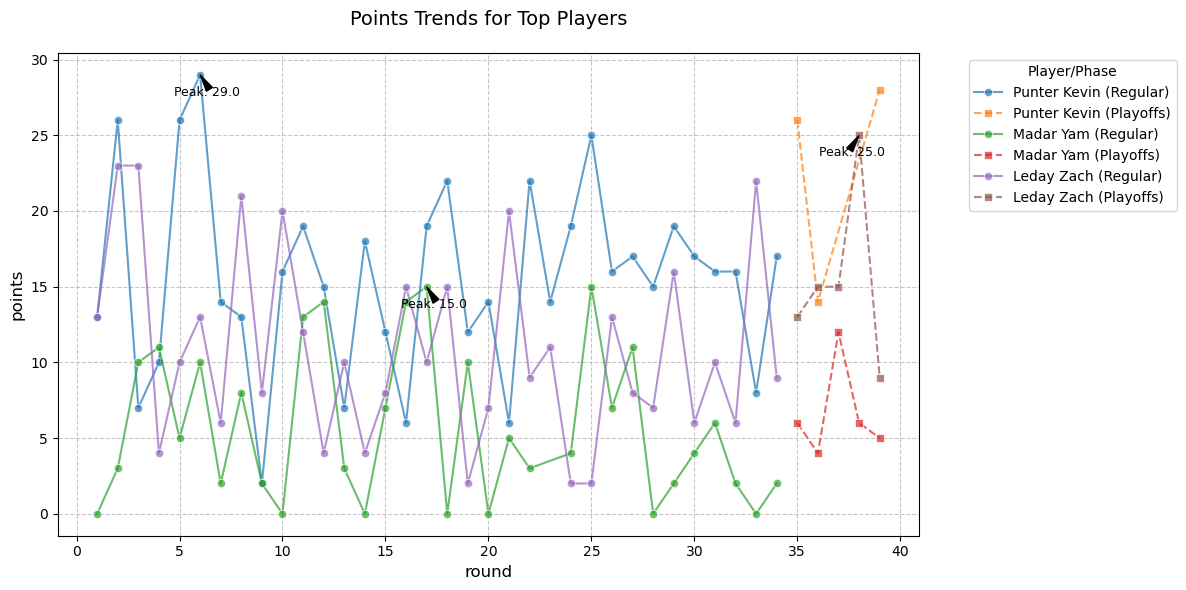

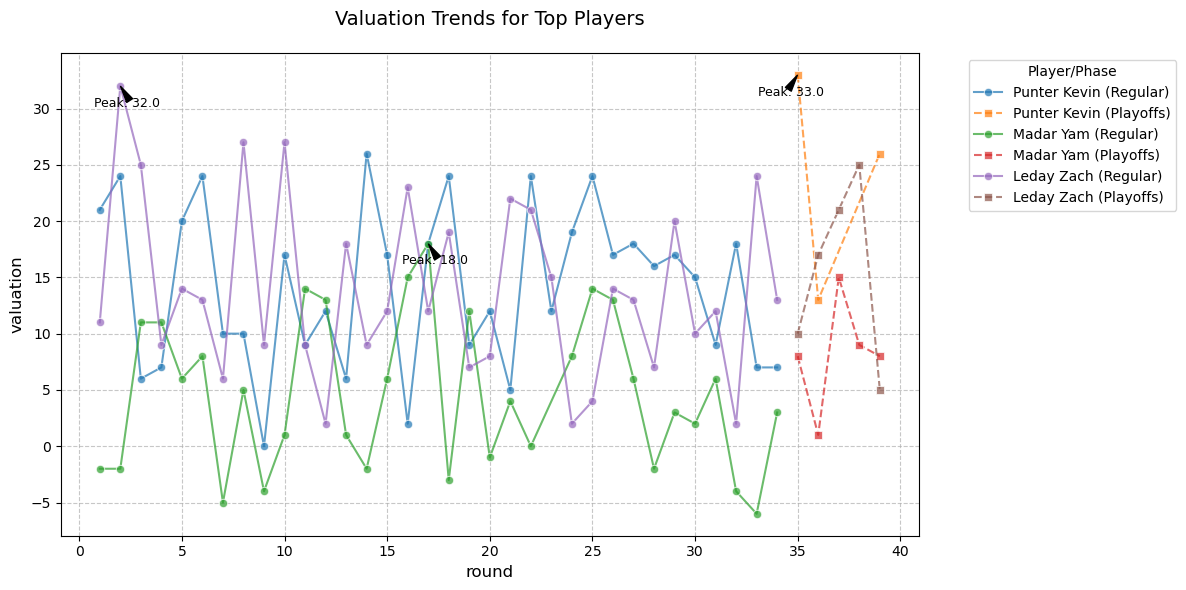

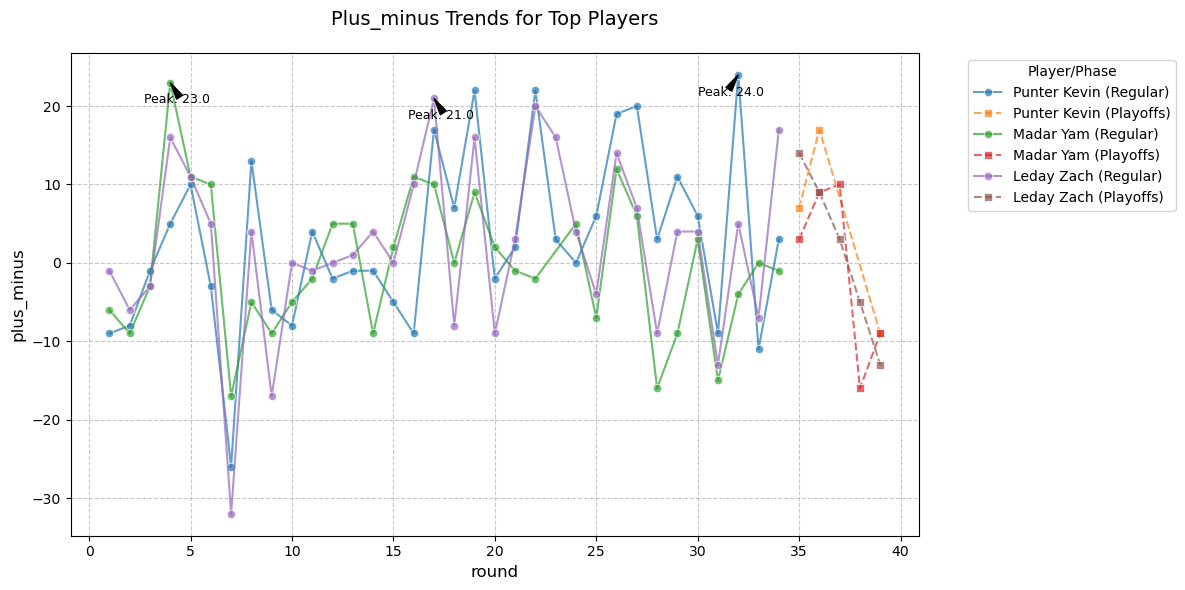

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# function to plot trends for all players on a single plot for a given metric
def plot_combined_trend(data, metric, players):
    plt.figure(figsize=(12, 6))
    
    # plot each player's trend
    for player_name in players:
        player_data = data[data['player'] == player_name].sort_values('round')
        regular_season = player_data[player_data['phase'] == 'REGULAR SEASON']
        playoffs = player_data[player_data['phase'] == 'PLAYOFFS']
        
        # plot regular season and playoffs with different styles
        sns.lineplot(x='round', y=metric, data=regular_season, marker='o', linestyle='-', 
                     label=f'{player_name} (Regular)', alpha=0.7)
        sns.lineplot(x='round', y=metric, data=playoffs, marker='s', linestyle='--', 
                     label=f'{player_name} (Playoffs)', alpha=0.7)
        
        # add peak annotation
        if not player_data.empty:
            max_val_round = player_data.loc[player_data[metric].idxmax(), 'round']
            max_val = player_data[metric].max()
            # dynamically adjust annotation position based on peak location
            y_offset = 5 if max_val < player_data[metric].mean() else -15  # place above if low, below if high
            x_offset = 5 if max_val_round < player_data['round'].mean() else -5  # place right if early, left if late
            plt.annotate(f'Peak: {max_val:.1f}', xy=(max_val_round, max_val), 
                         xytext=(x_offset, y_offset), textcoords='offset points',
                         arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5),
                         fontsize=9, ha='center')
    
    plt.title(f"{metric.capitalize()} Trends for Top Players", fontsize=14, pad=20)
    plt.xlabel('round', fontsize=12)
    plt.ylabel(f"{metric}", fontsize=12)
    plt.legend(title='Player/Phase', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# select top 3 players by valuation increase
top_valuation_players = phase_stats['valuation_diff'].nlargest(3).index


metrics = ['points', 'valuation', 'plus_minus']
for metric in metrics:
    plot_combined_trend(active_players[active_players['player'].isin(top_valuation_players)], 
                        metric, top_valuation_players)

### Output  

- **Points Plot:** A single plot showing points trends for **Punter Kevin**, **Madar Yam**, and **Leday Zach**, with regular season (solid lines, circles) and playoff (dashed lines, squares) phases distinguished. Peaks are annotated (e.g., Punter Kevin’s peak at 30.0).  
- **Valuation Plot:** A single plot showing valuation trends, with **Punter Kevin**’s sharp increase to 24.0, **Madar Yam**’s rise to 8.2, and **Leday Zach**’s more stable trend to 15.6.   
- **Plus/Minus Plot:** A single plot showing plus/minus trends, with annotations for each player’s peak value.

### Interpretation  

- **Punter Kevin**’s points and valuation trends show a clear upward trajectory in the playoffs, reinforcing his role as a clutch performer, though his valuation increase lacks statistical significance (p-value 0.2786).  
- **Madar Yam**’s valuation increase is noticeable, but his points and plus/minus trends are less dramatic, indicating a more specialized contribution.  
- **Leday Zach**’s points increase is evident, but his valuation and plus/minus trends suggest consistency rather than a significant leap, with a slight decline in plus/minus in the playoffs.

### Conclusion  

#### Key Findings  
The trend analysis reveals critical insights into Partizan Mozzart Bet Belgrade’s 2022/23 season:  

- **Punter Kevin** emerged as a standout performer, with significant increases in points (+7.17), valuation (+9.82), and plus/minus (average 3.00). However, the valuation increase is not statistically significant (p-value 0.2786), likely due to the small sample size (5 playoff games) and variability in performance.  
- **Madar Yam** showed promise, with a valuation increase of 3.68 (4.52 to 8.20), though his scoring improvement was modest (+0.90).  
- **Leday Zach** improved his scoring (+4.55) and valuation (+1.75), but his plus/minus declined slightly (average 2.05), indicating a mixed impact.  
- Team-level metrics showed a slight scoring increase (85.18 to 87.20) but a valuation decrease (93.91 to 91.80), suggesting improved offense but reduced overall efficiency in the playoffs. Individual player plus_minus values (e.g., **Punter Kevin**’s 3.00) suggest a positive team impact.  


#### Strategic Implications  
- **Punter Kevin** remains a key player in playoff scenarios, given his improvements across all metrics, despite the lack of statistical significance in his valuation increase.   
- **Madar Yam**’s valuation increase suggests he could be a valuable role player in the postseason, warranting more minutes to develop his impact.  
- **Leday Zach**’s scoring improvement is positive, but his plus/minus decline suggests a need to optimize his role or matchups in high-stakes games.  
- The team’s overall scoring improvement in the playoffs is encouraging, but the valuation decline indicates areas for improvement in efficiency and overall impact.